<a href="https://colab.research.google.com/github/reiinakano/neural-painters-pytorch/blob/master/notebooks/visualizing_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [1]:
!nvidia-smi

Thu Dec  5 07:29:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!rm -r neural-painters-pytorch
!rm -r neural_painters
!git clone https://github.com/reiinakano/neural-painters-pytorch.git
!cp -r neural-painters-pytorch/neural_painters neural_painters

rm: cannot remove 'neural-painters-pytorch': No such file or directory
rm: cannot remove 'neural_painters': No such file or directory
Cloning into 'neural-painters-pytorch'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 191 (delta 131), reused 127 (delta 71), pack-reused 0
Receiving objects: 100% (191/191), 815.92 KiB | 3.94 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [3]:
!pip install kornia

     |████████████████████████████████| 122kB 5.0MB/s 


In [4]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2019-12-05 07:29:34--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.07s   

2019-12-05 07:29:35 (500 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



# imports

In [5]:
import torch
import torchvision
import torchvision.utils as utils
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import json
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
import moviepy.editor as mpy

from neural_painters.vae_painter import VAENeuralPainter
from neural_painters.gan_painter import GANNeuralPainter
from neural_painters.data import FullActionStrokeDataLoader
from neural_painters.modules import NeuralCanvas, RandomRotate, Normalization
from neural_painters.viz import plot_images, animate_frames

import kornia

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3366912/45929032 bytes (7.3%)7643136/45929032 bytes (16.6%)11935744/45929032 bytes (26.0%)16138240/45929032 bytes (35.1%)20422656/45929032 bytes (44.5%)24756224/45929032 bytes (53.9%)28884992/45929032 bytes (62.9%)32972800/45929032 bytes (71.8%)37273600/45929032 bytes (81.2%)41459712/45929032 bytes (90.3%)45801472/45929032 bytes (99.7%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# all 0 to 1
ACTIONS_TO_IDX = {
    'pressure': 0,
    'size': 1,
    'control_x': 2,
    'control_y': 3,
    'end_x': 4,
    'end_y': 5,
    'color_r': 6,
    'color_g': 7,
    'color_b': 8,
    'start_x': 9,
    'start_y': 10,
    'entry_pressure': 11,
}

class_idx = json.load(open("imagenet_class_index.json"))
idx2label = {k: class_idx[str(k)][1] for k in range(len(class_idx))}
label2idx = {class_idx[str(k)][1]: k for k in range(len(class_idx))}

In [7]:
inception_v1 = torch.hub.load('pytorch/vision', 'googlenet', pretrained=True)
_ = inception_v1.eval().to(device)

squeezenet1_1 = torchvision.models.squeezenet1_1(pretrained=True)
_ = squeezenet1_1.eval().to(device)

vgg = torchvision.models.vgg19(pretrained=True)
_ = vgg.eval().to(device)

resnet = torchvision.models.resnet50(pretrained=True)
_ = resnet.eval().to(device)

mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
_ = mobilenet.eval().to(device)

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 47.7MB/s]
Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
100%|██████████| 4.74M/4.74M [00:00<00:00, 10.0MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:18<00:00, 30.9MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.8MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.

# Utility code for searching available ImageNet classes

You don't really need this but I found it helpful to look for classes to optimize.

In [16]:
def search(_search_term):
  print('searching matching labels for {}'.format(_search_term))
  print([x for x in label2idx if _search_term in x])

search('zeb')

searching matching labels for zeb
['zebra']


# Choosing parameters

In [35]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto", display-mode: "form" }

CATEGORY_TO_OPTIMIZE = "giant_panda" #@param {type:"string"}
#@markdown Some of my favorite categories are "bee", "giant_panda", "strawberry", "ice_bear", "pelican" 
search(CATEGORY_TO_OPTIMIZE)
CLASS_IDX = label2idx[CATEGORY_TO_OPTIMIZE]
NUM_STROKES = 30 #@param {type:"slider", min:1, max:100, step:1}
BATCH_SIZE = 5 #@param {type:"slider", min:1, max:5, step:1}
PAINTER_TYPE = "VAE" #@param ["GAN", "VAE"]
#@markdown VAE mode results in more solid strokes that are easier to optimize.
#@markdown GAN mode results in strokes that actually look like paintbrush strokes, although they might be harder to optimize.
STOCHASTIC = True #@param {type:"boolean"}
#@markdown Experimental. Adding uncertainty may (or may not) help produce more robust images.
LEARNING_RATE = 0.05 #@param {type: "number"}
TILE_SIZE = 3

#@markdown ---
#@markdown ### Choose which models are optimized *at the same time*:
USE_INCEPTION_V1 = True #@param {type:"boolean"}
USE_SQUEEZENET_1_1 = False #@param {type:"boolean"}
USE_VGG_19 = False #@param {type:"boolean"}
USE_MOBILENET_V2 = True #@param {type:"boolean"}
USE_RESNET_50 = True #@param {type:"boolean"}

MODELS_TO_OPTIMIZE = []
MODELS_TO_OPTIMIZE_STR = []
if USE_INCEPTION_V1:
  MODELS_TO_OPTIMIZE.append(inception_v1)
  MODELS_TO_OPTIMIZE_STR.append('inception v1')
if USE_SQUEEZENET_1_1:
  MODELS_TO_OPTIMIZE.append(squeezenet1_1)
  MODELS_TO_OPTIMIZE_STR.append('squeezenet 1_1')
if USE_VGG_19:
  MODELS_TO_OPTIMIZE.append(vgg)
  MODELS_TO_OPTIMIZE_STR.append('vgg 19')
if USE_MOBILENET_V2:
  MODELS_TO_OPTIMIZE.append(mobilenet)
  MODELS_TO_OPTIMIZE_STR.append('mobilenet v2')
if USE_RESNET_50:
  MODELS_TO_OPTIMIZE.append(resnet)
  MODELS_TO_OPTIMIZE_STR.append('resnet 50')

print("Category to optimize", CATEGORY_TO_OPTIMIZE, CLASS_IDX)
print("Number of strokes", NUM_STROKES)
print("Batch size", BATCH_SIZE)
print("Using {} painter".format(PAINTER_TYPE))
print("Stochastic", STOCHASTIC)
print("Learning Rate", LEARNING_RATE)
print("Models to optimize", MODELS_TO_OPTIMIZE_STR)
print('--------------------')


searching matching labels for giant_panda
['giant_panda']
Category to optimize giant_panda 388
Number of strokes 30
Batch size 5
Using VAE painter
Stochastic True
Learning Rate 0.05
Models to optimize ['inception v1', 'mobilenet v2', 'resnet 50']
--------------------


# Run optimization

Make sure to stop the optimization when you are happy with the results. Rarely do I need to go above 1500 steps.

Using cached checkpoint at /root/.cache/neural_painters/checkpoints/vae_neural_painter_latest.tar
Loaded from /root/.cache/neural_painters/checkpoints/vae_neural_painter_latest.tar. Batch 450000
Step 0	Cost 3.5678062438964844	Costs [0.22697908 0.3196479  0.20615865 0.38563305 0.07970838 0.3431681
 0.10358199 0.16041695 0.23864616 0.38040522 0.30960205 0.19142659
 0.16302814 0.34215465 0.1172494 ]


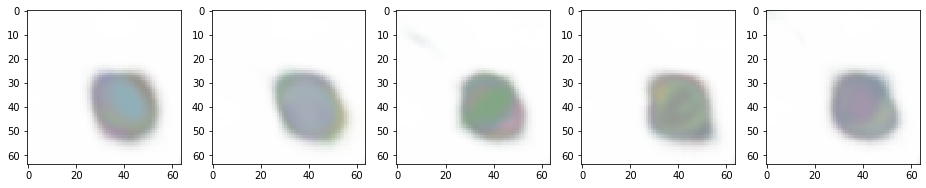

Step 100	Cost -53.02341079711914	Costs [-3.0340195 -3.7270474 -3.5481617 -4.2513013 -3.393553  -2.2813103
 -3.764305  -3.1078336 -4.8960533 -2.6244433 -3.5832617 -3.817088
 -3.3982217 -4.1878095 -3.4090014]


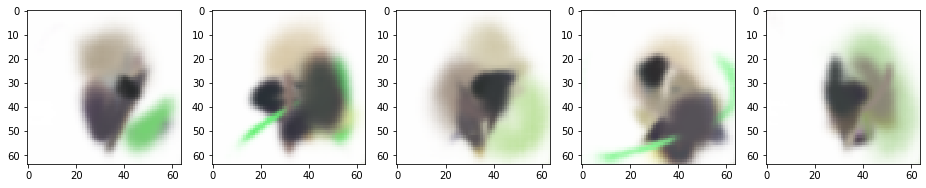

Step 200	Cost -79.46009063720703	Costs [-5.1068606 -5.7063217 -5.0520773 -6.0736814 -4.886569  -5.18309
 -5.6394925 -5.614783  -5.9274683 -4.5339923 -4.9161496 -5.659639
 -5.2535114 -6.1044183 -3.8020375]


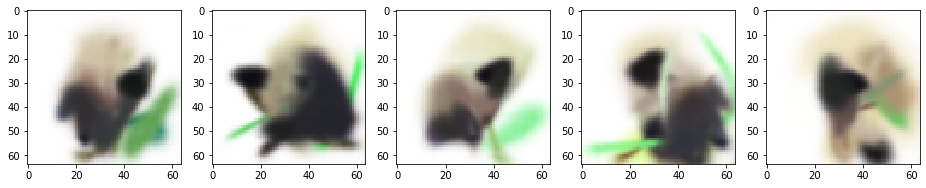

Step 300	Cost -85.70671844482422	Costs [-6.02188   -6.296757  -5.7143116 -7.311045  -3.4311676 -5.748846
 -6.373241  -5.1326337 -7.1479306 -4.4198422 -6.081953  -5.952185
 -5.793592  -6.105135  -4.1761985]


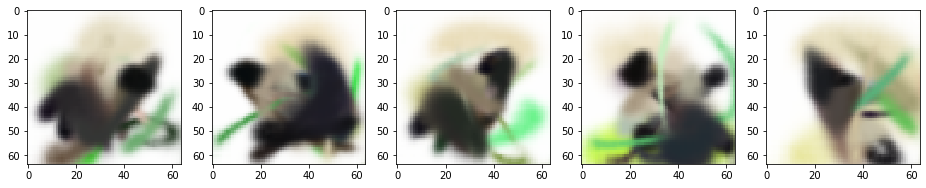

Step 400	Cost -100.1111831665039	Costs [-6.7605057 -5.8130116 -6.773261  -7.473892  -5.9066586 -5.9665437
 -6.979475  -6.5333    -7.6095395 -6.3376718 -6.709933  -5.556788
 -7.047397  -7.9538455 -6.689359 ]


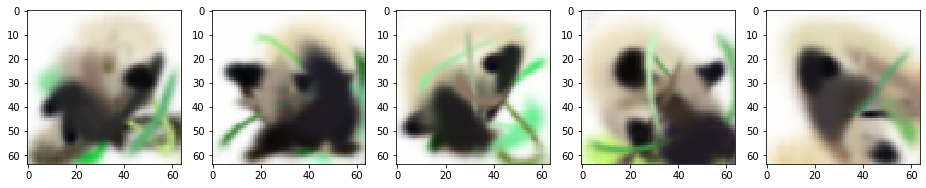

Step 500	Cost -102.57501220703125	Costs [-6.5682087 -6.6033716 -6.7518587 -8.620954  -6.465555  -7.0076594
 -7.020247  -6.59877   -7.916107  -6.3704047 -7.1929736 -6.866796
 -5.639874  -6.577605  -6.374634 ]


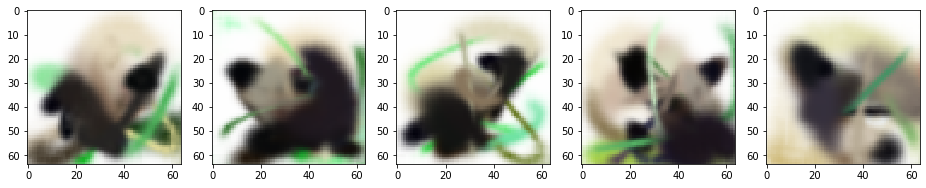

Step 600	Cost -111.58712768554688	Costs [-7.0063825 -7.6191125 -7.48507   -8.059396  -6.977654  -6.5052853
 -7.9086556 -7.2975364 -8.560917  -6.976561  -6.481031  -7.944897
 -7.6408277 -8.009844  -7.113956 ]


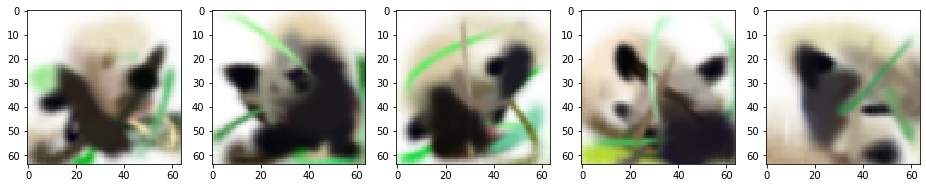

Step 700	Cost -113.74496459960938	Costs [-7.1429334 -7.3628592 -8.028676  -9.054761  -6.781398  -6.8745627
 -7.6545105 -7.8159094 -9.18535   -7.182029  -5.90412   -7.3378396
 -8.062378  -8.489929  -6.867704 ]


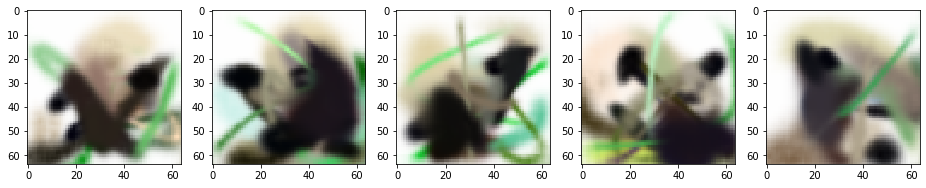

Step 800	Cost -109.87742614746094	Costs [-7.395083  -7.0717487 -7.933226  -9.628952  -6.269361  -6.927903
 -6.0870156 -7.7244    -9.430328  -7.4284306 -6.3967996 -5.6806173
 -6.3795657 -9.361104  -6.162884 ]


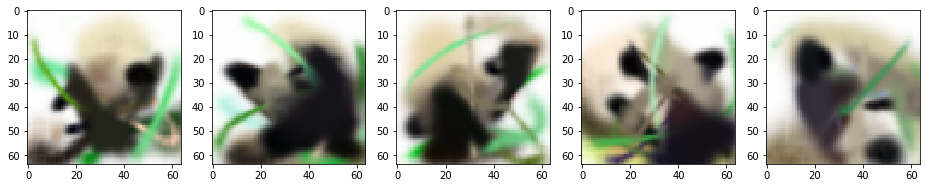

Step 900	Cost -112.41032409667969	Costs [-8.696187  -8.732732  -6.5820923 -8.604237  -6.4519305 -8.017988
 -7.3036566 -5.0067267 -8.011734  -7.6315675 -8.3392    -7.9000506
 -6.4674845 -8.090476  -6.574257 ]


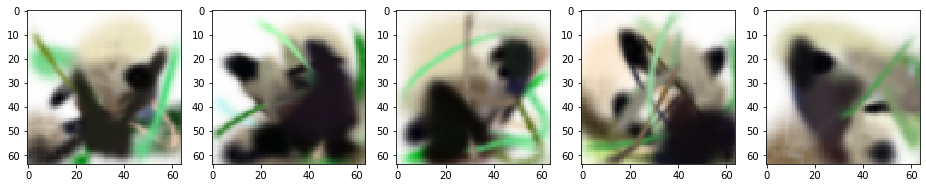

KeyboardInterrupt: ignored

In [36]:
if PAINTER_TYPE == 'VAE':
  neural_painter = VAENeuralPainter(action_size=len(ACTIONS_TO_IDX), z_size=64, stochastic=STOCHASTIC, 
                                    pretrained=True).to(device).eval()
elif PAINTER_TYPE == 'GAN':
  neural_painter = GANNeuralPainter(action_size=len(ACTIONS_TO_IDX), noise_dim=16, 
                                    num_deterministic=0 if STOCHASTIC else 16, pretrained=True).to(device).eval()
else:
  raise NotImplementedError

canvas = NeuralCanvas(neural_painter=neural_painter)

actions = torch.FloatTensor(NUM_STROKES, BATCH_SIZE, len(ACTIONS_TO_IDX)).uniform_().to(device)

optimizer = optim.Adam([actions.requires_grad_()], lr=LEARNING_RATE)

normalizer = Normalization(torch.tensor([0.485, 0.456, 0.406]).to(device), 
                           torch.tensor([0.229, 0.224, 0.225]).to(device))
#normalizer = Normalization(torch.tensor([0.5, 0.5, 0.5]).to(device), 
#                           torch.tensor([0.5, 0.5, 0.5]).to(device))
random_rotater = RandomRotate(angle=20)

canvases = []
for idx in range(1500):
  optimizer.zero_grad()

  # Generate final canvas with all strokes
  output_canvas, _ = canvas(actions.sigmoid())
  canvases.append(output_canvas.detach().cpu())

  # Image transformations
  tiled_canvas = output_canvas.repeat(TILE_SIZE, 1, 1, 1)
  augmented_canvas = random_rotater(normalizer(tiled_canvas))
  augmented_canvas = F.interpolate(augmented_canvas, size=[224, 224], mode='bilinear')

  # Pass through pretrained
  out_classes = 0
  for clf in MODELS_TO_OPTIMIZE:
    out_classes += clf(augmented_canvas)
  out_classes = out_classes / (float(len(MODELS_TO_OPTIMIZE)) * float(TILE_SIZE))

  costs = -out_classes[:, CLASS_IDX]
  cost = costs.sum()
  cost.backward()
  optimizer.step()
  if idx % 100 == 0:
    print(f'Step {idx}\tCost {cost.item()}\tCosts {costs.detach().cpu().numpy()}')
    plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1))
    plt.show()


# Visualize and watch the canvas "bloom"

In [37]:
def animate_canvases(canvases: List[torch.Tensor], skip_every_n: int = 1):
  canvases = canvases[::skip_every_n]
  canvases = [(x.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1)
              for x in canvases]
  canvases = [np.concatenate(x, axis=1) for x in canvases]
  animate_frames(canvases, 'tmp.mp4')

animate_canvases(canvases, skip_every_n=2)
display(mpy.ipython_display('tmp.mp4', height=150, max_duration=100.))

[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


100%|█████████▉| 460/461 [00:01<00:00, 399.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 

